# EEG Data - Group Analysis

Analyze aperiodic activity across the group (MIPDB Dataset).

In [1]:
%matplotlib inline

import os
import csv

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar, rcParams

import mne

In [2]:
# Import custom project related code
import sys
sys.path.append('../')

# Import custom project related code
from core.utils import comb_corrs, bet_corrs
from core.db import EEGDB
from core.io import load_pickle
from core.plts import plot_scatter

## Settings

In [3]:
#corr_func = spearmanr
corr_func = pearsonr

In [4]:
SAVE_FIG = False

## Setup

In [5]:
# Get project database object
db = EEGDB()

In [6]:
# Load data readme file
rmd_file = os.path.join(db.data_path, 'EEG', 'MIPDB_PublicFile.csv')
rmd_df = pd.read_csv(rmd_file, index_col='ID')

### Load subject data

In [7]:
# Check for saved FOOOF files
fres_files = db.check_fooof()

In [8]:
# Load all data into a list
all_data = [load_pickle(f_name, db.fooof_path) for f_name in fres_files]

# Check number of subjects
n_subjs = len(all_data)
print(n_subjs, ' subjects.')

98  subjects.


In [9]:
# Initialize dataframe to store aperiodic data
ap_df = pd.DataFrame(columns=['ID', 'age',
                              'mean_exp_EO', 'median_exp_EO',
                              'mean_exo_EC', 'median_exp_EC'])

# Collect data from all subjects
for data in all_data:
    
    ap_data = {'ID': data['ID'],
               'age': rmd_df.loc[data['ID']]['Age'],
               'mean_exp_EO': np.mean(data['sls_eo_avg']),
               'median_exp_EO': np.median(data['sls_eo_avg']),
               'mean_exp_EC': np.mean(data['sls_ec_avg']),
               'median_exp_EC': np.median(data['sls_ec_avg'])}
    
    ap_df = ap_df.append(ap_data, ignore_index=True)

In [10]:
# Check out the dataframe
ap_df.head()

,ID,age,mean_exp_EO,median_exp_EO,mean_exo_EC,median_exp_EC,mean_exp_EC
0,A00062704,32.0,1.501144,1.515592,NaN,1.398595,1.407570
1,A00054930,18.0,1.652110,1.669927,NaN,1.899271,1.887614
2,A00062919,22.0,1.031232,1.024979,NaN,1.311356,1.290424
3,A00062578,32.0,0.862034,0.819549,NaN,0.455303,0.490674
4,A00053440,12.0,2.010997,2.047516,NaN,1.927993,1.879631


In [11]:
# Descriptive statistics
ap_df.describe()

,age,mean_exp_EO,median_exp_EO,mean_exo_EC,median_exp_EC,mean_exp_EC
count,98.000000,98.000000,98.000000,0.0,98.000000,98.000000
mean,15.459184,1.619074,1.627296,NaN,1.675245,1.671736
std,7.857190,0.336503,0.332027,NaN,0.335790,0.332694
min,6.000000,0.862034,0.819549,NaN,0.455303,0.490674
25%,10.000000,1.385970,1.386807,NaN,1.441390,1.432952
50%,13.000000,1.656187,1.670512,NaN,1.692239,1.693712
75%,17.750000,1.899327,1.892204,NaN,1.912264,1.903880
max,44.000000,2.268051,2.260224,NaN,2.408580,2.383702


### TITLE

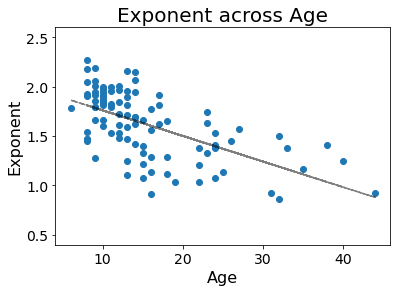

In [12]:
# Plot exponent data relation to age - EO
plot_scatter(ap_df['age'], ap_df['mean_exp_EO'], ylim=[0.4, 2.6],
             title='Exponent across Age', xlabel='Age', ylabel='Exponent', 
             save_fig=SAVE_FIG, file_name='')

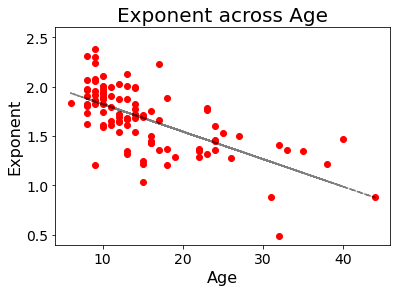

In [13]:
# Plot exponent data relation to age - EO
plot_scatter(ap_df['age'], ap_df['mean_exp_EC'], ylim=[0.4, 2.6], color='red',
             title='Exponent across Age', xlabel='Age', ylabel='Exponent', 
             save_fig=SAVE_FIG, file_name='')

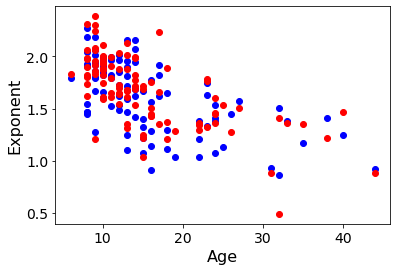

In [71]:
# Plot EC & EO Data Together
_, ax = plt.subplots()
plot_scatter(ap_df.age, ap_df.mean_exp_EO,
             color='blue', add_line=False, ax=ax)
plot_scatter(ap_df.age, ap_df.mean_exp_EC,
             xlabel='Age', ylabel='Exponent', 
             color='red', add_line=False, ax=ax)

In [72]:
# Check the correlation between exponent & age, for EO & EC
print(corr_func(ap_df.age, ap_df.median_exp_EO))
print(corr_func(ap_df.age, ap_df.median_exp_EC))

(-0.6112331603413075, 2.317443911353895e-11)
(-0.6567158886887846, 2.0985351346445964e-13)


In [73]:
# Check correlation separately in 'kids' & 'adults'

# Kids
inds = ap_df.age < 18
print('Kids Age & Exp correlation (n = {})'.format(sum(inds)))
print('\t', corr_func(ap_df.age[inds], ap_df.mean_exp_EC[inds]))

# Adults
inds = ap_df.age > 18
print('Adults Age & Exp correlation (n = {})'.format(sum(inds)))
print('\t', corr_func(ap_df.age[inds], ap_df.mean_exp_EC[inds]))

Kids Age & Exp correlation (n = 73)
	 (-0.47585895266370515, 2.0912011829824157e-05)
Adults Age & Exp correlation (n = 22)
	 (-0.4323370413097024, 0.04448532853360572)


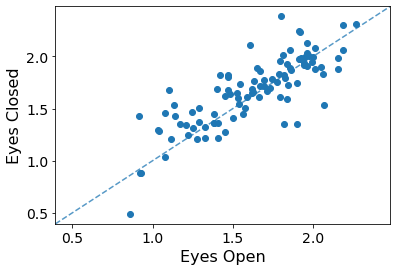

In [74]:
# Plot EC & EO Data Together
plot_scatter(ap_df.mean_exp_EO, ap_df.mean_exp_EC,
             xlabel='Eyes Open', ylabel='Eyes Closed', 
             add_line=False, add_equal=True)

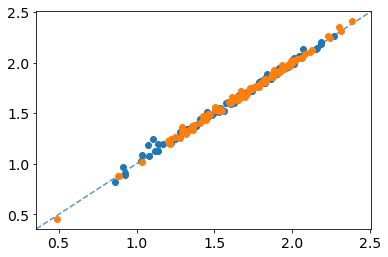

In [75]:
# Compare mean vs median
_, ax = plt.subplots()
plot_scatter(ap_df.mean_exp_EO, ap_df.median_exp_EO,
             add_line=False, ax=ax)
plot_scatter(ap_df.mean_exp_EC, ap_df.median_exp_EC, 
             add_line=False, add_equal=True, ax=ax)

In [76]:
# Correlation between EC and EO data
print(corr_func(ap_df.median_exp_EO, ap_df.median_exp_EC))

(0.8095133275231613, 6.24618165604998e-24)


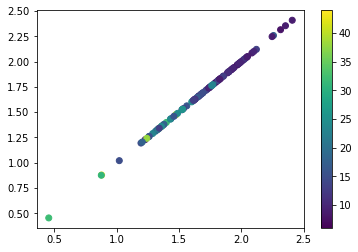

In [77]:
# Scatter with colormap mapping to z value
plt.scatter(ap_df.median_exp_EC, ap_df.median_exp_EC, c=ap_df.age)
plt.colorbar()

### Group Topo Plots

In [78]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../data/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
n_chs = len(ch_labels)

# Read channel montage
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')

# Create the info structure needed by MNE
info = mne.create_info(ch_labels, 500, 'eeg')

# Create the MNE Raw data object
raw = mne.io.RawArray(np.zeros([111, 1]), info, verbose=False)
raw = raw.set_montage(montage)

In [79]:
# Create average exponent values, averaged across all subjects

# Initialize arrays, and grab average slope results
exp_eo = np.zeros(shape=[n_chs, n_subjs])
exp_ec = np.zeros(shape=[n_chs, n_subjs])
for ind, data in enumerate(all_data):
    exp_eo[:, ind] = data['sls_eo_avg']
    exp_ec[:, ind] = data['sls_ec_avg']
    
# Average across subjects
exp_eo_avg = exp_eo.mean(axis=1)
exp_ec_avg = exp_ec.mean(axis=1)

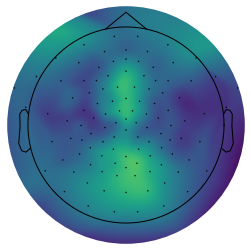

In [80]:
# Plot exponent topography from average eyes-open data
fig, ax = plt.subplots()
mne.viz.plot_topomap(exp_eo_avg, raw.info, contours=0,
                     cmap=cm.viridis, vmin=1.5, vmax=1.8, axes=ax);
if SAVE_FIG:
    fig.savefig('EO-exponent' + '.pdf')

In [81]:
# Check range of data values
print('Min: ', exp_eo_avg.min())
print('Max: ', exp_eo_avg.max())

Min:  1.5418296748706095
Max:  1.7165460936771466


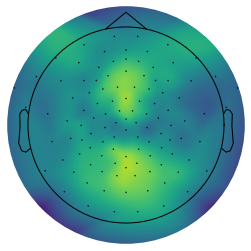

In [82]:
# Plot slope topography from average eyes-closed data
fig, ax = plt.subplots()
mne.viz.plot_topomap(exp_ec_avg, raw.info, contours=0,
                     cmap=cm.viridis, vmin=1.5, vmax=1.8, axes=ax);
if SAVE_FIG:
    fig.savefig('EC-Slope.png', dpi=600)

In [83]:
# Check range of data values
print('Min: ', exp_ec_avg.min())
print('Max: ', exp_ec_avg.max())

Min:  1.5919116035833807
Max:  1.763770791515523


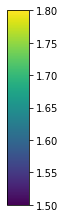

In [84]:
# Create a colorbar for the topography plots
fig = plt.figure(figsize=(2, 3))
ax1 = fig.add_axes([0.9, 0.25, 0.15, 0.9])

cmap = cm.viridis
norm = colors.Normalize(vmin=1.5, vmax=1.8)

cb1 = colorbar.ColorbarBase(plt.gca(), cmap=cmap,
                            norm=norm,
                            orientation='vertical')

if SAVE_FIG:
    plt.savefig('colorbar.png', format='png', bbox_inches='tight', dpi=300)

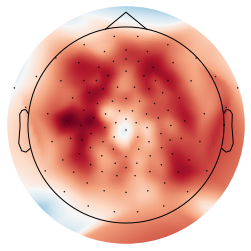

In [85]:
# Create a slope difference topography - between EC & EO
diff_exp = [exp_ec - exp_eo for exp_ec, exp_eo in zip(exp_ec_avg, exp_eo_avg)]
mne.viz.plot_topomap(diff_exp, raw.info, contours=0);

In [86]:
# Check the range of differences between EC & EO
temp = 'EC/EO range of differences: {:0.4f} to {:0.4f}.'
print(temp.format(min(diff_exp), max(diff_exp)))

EC/EO range of differences: -0.0077 to 0.0978.


In [87]:
# Check the correlation between EC and EO data
corr_func(exp_ec_avg, exp_eo_avg)

(0.8825443237644706, 1.6486855699568036e-37)

### Consistency Measures: Correlations Within & Between Epochs & State

In [88]:
# Calculate correlations within subjects, within and between states
corrs_eo = []
corrs_ec = []
corrs_bet = []

for data in all_data:
    
    corrs_eo.append(np.mean(comb_corrs(data['sls_eo'])))
    corrs_ec.append(np.mean(comb_corrs(data['sls_ec'])))
    corrs_bet.append(np.mean(bet_corrs(data['sls_eo'], data['sls_ec'])))

corrs_ec = [it for it in corrs_ec if not np.isnan(it)]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [89]:
# Calculate correlations between subjects, within and between states
corrs_diff_eo = []
corrs_diff_ec = []
corrs_diff_ec_eo = []

for ii, jj in zip(range(n_subjs-1), range(1, n_subjs)):
    
    corrs_diff_eo.append(np.mean(bet_corrs(all_data[ii]['sls_ec'],
                                           all_data[jj]['sls_ec'])))
    
    corrs_diff_ec.append(np.mean(bet_corrs(all_data[ii]['sls_eo'],
                                           all_data[jj]['sls_eo'])))
    
    corrs_diff_ec_eo.append(np.mean(bet_corrs(all_data[ii]['sls_ec'],
                                              all_data[jj]['sls_eo'])))

In [90]:
# Collect all correlations, and labels, together
all_corrs = [corrs_ec, corrs_eo, corrs_bet,
             corrs_diff_ec, corrs_diff_eo, corrs_diff_ec_eo]    
corr_labels = ['EC-Within', 'EO-Within', 'EC/EO-Within',
               'EC-Between', 'EO-Between', 'EO/EC-Between']

In [91]:
# Check average correlation values within & between states & subjects
for corr, label in zip(all_corrs, corr_labels):
    print(label, '\t{:0.4f}'.format(np.mean(corr)))

EC-Within 	0.5260
EO-Within 	0.3977
EC/EO-Within 	0.3807
EC-Between 	0.0448
EO-Between 	0.0572
EO/EC-Between 	0.0501


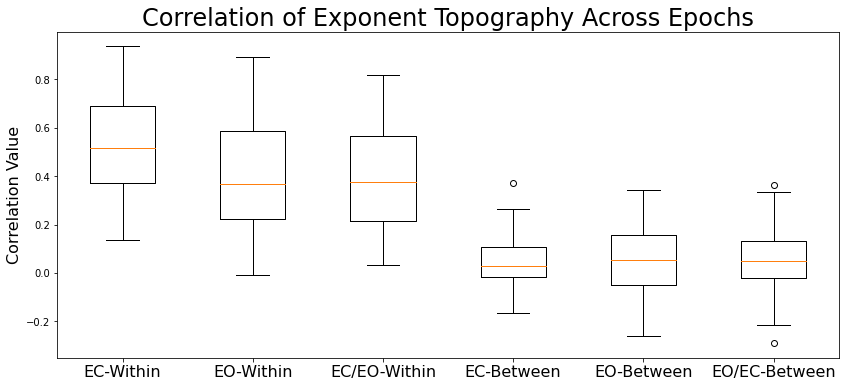

In [92]:
# Plot the correlations across epochs
fig, ax = plt.subplots(figsize=(14, 6))
plt.boxplot(all_corrs);

plt.title('Correlation of Exponent Topography Across Epochs', fontsize=24);
plt.ylabel('Correlation Value', fontsize=16);

xtickNames = plt.setp(ax, xticklabels=corr_labels)
plt.setp(xtickNames, fontsize=16);

# Save out figure
if SAVE_FIG:
    plt.savefig('topo_corr_boxplot.png', format='png', bbox_inches='tight', dpi=300)

### Spatial Correlations

In [93]:
pos = np.asarray([ch['loc'][:3] for ch in raw.info['chs']])

In [94]:
#from mne.channels.layout import _pol_to_cart, _cart_to_sph
#pos = _pol_to_cart(_cart_to_sph(pos)[:, 1:][:, ::-1])

In [95]:
# Check the spatial correlation
ind = 2
print(corr_func(exp_ec_avg, pos[:, ind]))
print(corr_func(exp_eo_avg, pos[:, ind]))

(0.37567574347941035, 4.843586950886238e-05)
(0.3099137398853195, 0.0009327142484003467)


In [96]:
# Check the spatial correlation
ind = 1
print(corr_func(exp_ec_avg, pos[:, ind]))
print(corr_func(exp_eo_avg, pos[:, ind]))

(-0.18416671555437775, 0.05299801321701032)
(-0.2966916094070773, 0.001567059544717424)


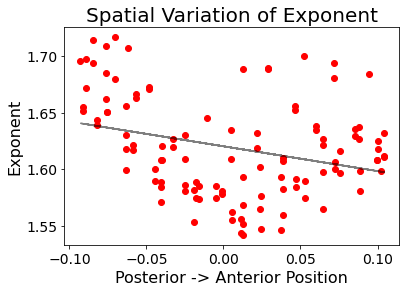

In [98]:
# Plot relation between exponents and position
plot_scatter(pos[:, ind], exp_eo_avg, color='red', 
             title='Spatial Variation of Exponent',
             xlabel='Posterior -> Anterior Position', ylabel='Exponent',
             save_fig=SAVE_FIG, file_name='ant_pos_corr')

In [99]:
# Check the spatial correlation
ind = 0
print(corr_func(exp_ec_avg, abs(pos[:, ind])))
print(corr_func(exp_eo_avg, abs(pos[:, ind])))

(-0.665579560369175, 1.5977635343064186e-15)
(-0.7636205522421178, 1.938245904806582e-22)


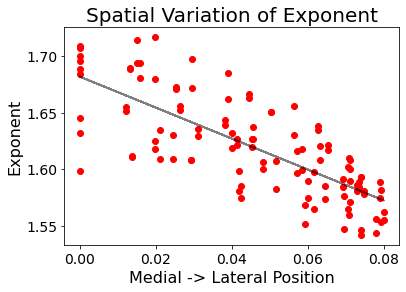

In [101]:
# Plot relation between exponents and position
ind = 0
plot_scatter(abs(pos[:, ind]), exp_eo_avg, color='red',
             title='Spatial Variation of Exponent',
             xlabel='Medial -> Lateral Position', ylabel='Exponent',
             save_fig=SAVE_FIG, file_name='ant_pos_corr')